[Top-2 eigvec] Subspace alignment score: 0.0950
[Best-2 overlap] Subspace alignment score: 0.1148


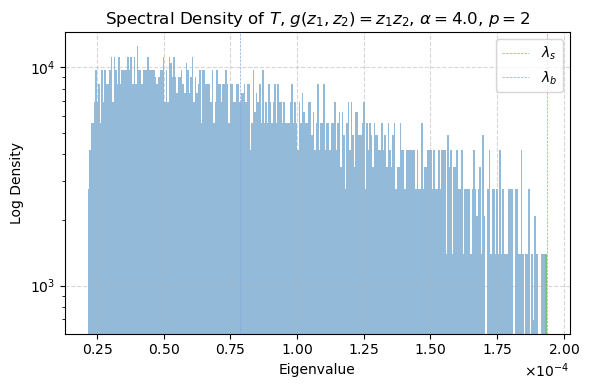

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv as besselk
from scipy.linalg import eigh
from matplotlib.ticker import ScalarFormatter


def compute_T_y_bessel(y_batch):
    """Compute T(y) using the Bessel-based formulation."""
    abs_y = np.abs(y_batch)
    K1 = besselk(1, abs_y)
    K0 = besselk(0, abs_y)
    with np.errstate(divide='ignore', invalid='ignore'):
        lambda_y = abs_y * (K1 / K0)
        lambda_y[np.isnan(lambda_y)] = 0.0
        lambda_y[np.isinf(lambda_y)] = 0.0

    T_list = []
    for i in range(len(y_batch)):
        y_i = y_batch[i]
        lam = lambda_y[i]
        G = np.array([[lam, y_i],
                      [y_i, lam]])
        T_i = G @ np.linalg.inv(G + np.eye(2))
        T_list.append(T_i)
    return np.array(T_list)  # shape: (n, 2, 2)


def build_T_hat(X, T_y):
    """Construct the block-structured spectral matrix T_hat."""
    n, d = X.shape
    T_matrix = np.zeros((2 * d, 2 * d))
    for i in range(n):
        xi = X[i]           # (d,)
        Ti = T_y[i]         # (2, 2)
        A = np.outer(xi, xi)  # (d, d)

        # Blockwise accumulation equivalent to a Kronecker structure
        T_matrix[0:d, 0:d]     += Ti[0, 0] * A
        T_matrix[0:d, d:2*d]   += Ti[0, 1] * A
        T_matrix[d:2*d, 0:d]   += Ti[1, 0] * A
        T_matrix[d:2*d, d:2*d] += Ti[1, 1] * A
    T_matrix /= n
    return T_matrix


def plot_spectrum(eigvals, alpha, p, signal_top=2, lambda_s=None, lambda_b=None, save_path=None):
    """Plot the spectral density and highlight signal eigenvalues."""
    bulk_color = '#2878B5'
    signal_color = 'green'

    # Histogram of eigenvalues
    hist, bin_edges = np.histogram(eigvals, bins=300, density=True)
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    eigvals_sorted = np.sort(eigvals)
    signal_eigs = eigvals_sorted[-signal_top:]
    signal_bins = set(np.digitize(signal_eigs, bin_edges) - 1)

    plt.figure(figsize=(6, 4))
    for i in range(len(hist)):
        color = signal_color if i in signal_bins else bulk_color
        plt.bar(bin_centers[i], hist[i], width=bin_width, color=color, alpha=0.5)

    if lambda_s is not None:
        plt.axvline(lambda_s, color='#36E072', linestyle='--', linewidth=0.5, label=r'$\lambda_s$')
    if lambda_b is not None:
        plt.axvline(lambda_b, color='#85A7E7', linestyle='--', linewidth=0.5, label=r'$\lambda_b$')

    plt.yscale('log')
    plt.title(r"Spectral Density of $T$, $g(z_1,z_2)=z_1z_2$, $\alpha={:.1f}$, $p={}$".format(alpha, p))
    plt.xlabel("Eigenvalue")
    plt.ylabel("Log Density")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()

    ax = plt.gca()
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


def orthonormalize(A):
    """Orthonormalize columns using QR decomposition."""
    Q, _ = np.linalg.qr(A)
    return Q


def compute_alignment(W_hat, W_star):
    """Compute subspace alignment score between W_hat and W_star."""
    Q1 = orthonormalize(W_hat)
    Q2 = orthonormalize(W_star)
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)


def main():
    # Parameter settings
    d = 1250
    p = 2
    alpha = 4
    n = int(d * alpha)
    np.random.seed(42)

    # Generate true signal subspace and synthetic data
    W_star = np.random.randn(d, p)
    W_star, _ = np.linalg.qr(W_star)
    X = np.random.randn(n, d) / np.sqrt(d)
    Z = X @ W_star
    z1, z2 = Z[:, 0], Z[:, 1]
    y = z1 * z2  # Link function g(z1,z2)=z1*z2

    # Compute T(y) and construct T_hat
    T_y = compute_T_y_bessel(y)
    T_hat = build_T_hat(X, T_y)

    # Eigen-decomposition
    eigvals, eigvecs = eigh(T_hat)

    # Subspace alignment using top-p eigenvectors
    top_vectors = eigvecs[:, -p:]  # shape: (2d, p)
    W_hat = np.zeros((d, p))
    for j in range(p):
        W_hat[:, j] = top_vectors[j * d:(j + 1) * d, j]
    alignment_score = compute_alignment(W_hat, W_star)
    print(f"[Top-{p} eigvec] Subspace alignment score: {alignment_score:.4f}")

    # Subspace alignment using best-overlap eigenvectors
    overlaps = []
    for i in range(2 * d):
        vec = eigvecs[:, i]
        v1 = vec[:d]
        overlap_score = np.sum((W_star.T @ v1) ** 2)
        overlaps.append((i, overlap_score))
    overlaps.sort(key=lambda x: x[1], reverse=True)

    best_indices = [idx for idx, _ in overlaps[:p]]
    W_hat_best = np.zeros((d, p))
    for j, idx in enumerate(best_indices):
        W_hat_best[:, j] = eigvecs[:d, idx]
    improved_score = compute_alignment(W_hat_best, W_star)
    print(f"[Best-{p} overlap] Subspace alignment score: {improved_score:.4f}")

    # Plot spectral density
    lambda_s = eigvals[-1]
    lambda_b = eigvals[d - 1]
    plot_spectrum(eigvals, alpha=alpha, p=p, lambda_s=lambda_s, lambda_b=lambda_b)


if __name__ == "__main__":
    main()


[Top-2 eigvec] Subspace alignment score: 0.0950
[Best-2 overlap] Subspace alignment score: 0.1148
Best-2 eigvec indices: [2284, 2317]
Corresponding eigenvalues: [0.00015534842881574474, 0.00015946351324127404]


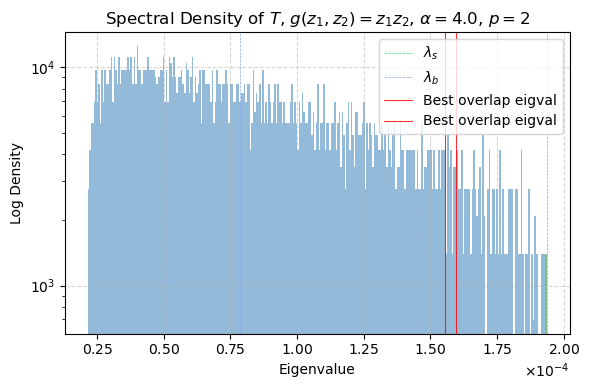

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv as besselk
from scipy.linalg import eigh
from matplotlib.ticker import ScalarFormatter


def compute_T_y_bessel(y_batch):
    """Compute T(y) using the Bessel-based formulation."""
    abs_y = np.abs(y_batch)
    K1 = besselk(1, abs_y)
    K0 = besselk(0, abs_y)
    with np.errstate(divide='ignore', invalid='ignore'):
        lambda_y = abs_y * (K1 / K0)
        lambda_y[np.isnan(lambda_y)] = 0.0
        lambda_y[np.isinf(lambda_y)] = 0.0

    T_list = []
    for i in range(len(y_batch)):
        y_i = y_batch[i]
        lam = lambda_y[i]
        G = np.array([[lam, y_i],
                      [y_i, lam]])
        T_i = G @ np.linalg.inv(G + np.eye(2))
        T_list.append(T_i)
    return np.array(T_list)


def build_T_hat(X, T_y):
    """Construct the block-structured spectral matrix T_hat."""
    n, d = X.shape
    T_matrix = np.zeros((2 * d, 2 * d))
    for i in range(n):
        xi = X[i]
        Ti = T_y[i]
        A = np.outer(xi, xi)

        # Blockwise accumulation equivalent to a Kronecker structure
        T_matrix[0:d, 0:d]     += Ti[0, 0] * A
        T_matrix[0:d, d:2*d]   += Ti[0, 1] * A
        T_matrix[d:2*d, 0:d]   += Ti[1, 0] * A
        T_matrix[d:2*d, d:2*d] += Ti[1, 1] * A
    T_matrix /= n
    return T_matrix


def plot_spectrum(eigvals, alpha, p, signal_top=2, lambda_s=None, lambda_b=None, lambda_best=None, save_path=None):
    """Plot the spectral density and highlight signal and best-overlap eigenvalues."""
    bulk_color = '#2878B5'
    signal_color = 'green'
    best_color = 'red'

    hist, bin_edges = np.histogram(eigvals, bins=300, density=True)
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    eigvals_sorted = np.sort(eigvals)
    signal_eigs = eigvals_sorted[-signal_top:]
    signal_bins = set(np.digitize(signal_eigs, bin_edges) - 1)

    plt.figure(figsize=(6, 4))
    for i in range(len(hist)):
        color = signal_color if i in signal_bins else bulk_color
        plt.bar(bin_centers[i], hist[i], width=bin_width, color=color, alpha=0.5)

    # Mark λ_s and λ_b
    if lambda_s is not None:
        plt.axvline(lambda_s, color='#36E072', linestyle='--', linewidth=0.5, label=r'$\lambda_s$')
    if lambda_b is not None:
        plt.axvline(lambda_b, color='#85A7E7', linestyle='--', linewidth=0.5, label=r'$\lambda_b$')

    # Mark eigenvalues selected by best-overlap criterion
    if lambda_best is not None:
        for val in lambda_best:
            plt.axvline(val, color=best_color, linestyle='-', linewidth=0.8, alpha=0.8, label='Best overlap eigval')
        plt.legend()

    plt.yscale('log')
    plt.title(r"Spectral Density of $T$, $g(z_1,z_2)=z_1z_2$, $\alpha={:.1f}$, $p={}$".format(alpha, p))
    plt.xlabel("Eigenvalue")
    plt.ylabel("Log Density")
    plt.grid(True, linestyle='--', alpha=0.5)

    ax = plt.gca()
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='x', style='sci',_


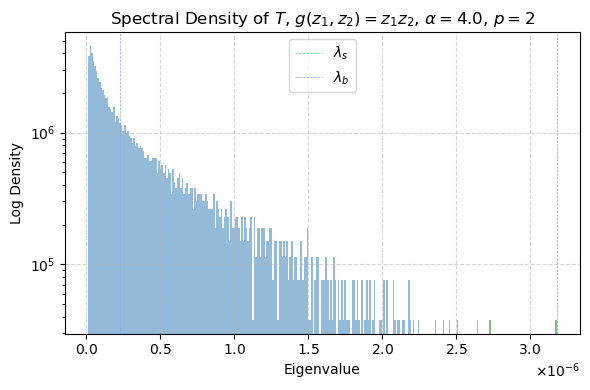

Subspace Alignment Score (normalized): 0.0011


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv as besselk
from scipy.linalg import eigh
from matplotlib.ticker import ScalarFormatter


def compute_T_y_bessel(y_batch):
    """Compute T(y) using the Bessel-based formulation."""
    abs_y = np.abs(y_batch)
    K1 = besselk(1, abs_y)
    K0 = besselk(0, abs_y)
    with np.errstate(divide='ignore', invalid='ignore'):
        lambda_y = abs_y * (K1 / K0)
        lambda_y[np.isnan(lambda_y)] = 0.0
        lambda_y[np.isinf(lambda_y)] = 0.0

    T_list = []
    for i in range(len(y_batch)):
        y_i = y_batch[i]
        lam = lambda_y[i]
        G = np.array([[lam, y_i],
                      [y_i, lam]])
        T_i = G @ np.linalg.inv(G + np.eye(2))
        T_list.append(T_i)
    return np.array(T_list)


def build_T_hat(X, T_y):
    """Construct the block-structured spectral matrix T_hat."""
    n, d = X.shape
    T_matrix = np.zeros((2 * d, 2 * d))
    for i in range(n):
        xi = X[i]
        Ti = T_y[i]
        A = np.outer(xi, xi)

        # Blockwise accumulation equivalent to a Kronecker structure
        T_matrix[0:d, 0:d]     += Ti[0, 0] * A
        T_matrix[0:d, d:2*d]   += Ti[0, 1] * A
        T_matrix[d:2*d, 0:d]   += Ti[1, 0] * A
        T_matrix[d:2*d, d:2*d] += Ti[1, 1] * A
    T_matrix /= n
    return T_matrix


def plot_spectrum(eigvals, alpha, p, signal_top=2, lambda_s=None, lambda_b=None, lambda_best=None, save_path=None):
    """Plot the spectral density and highlight signal and best-overlap eigenvalues."""
    bulk_color = '#2878B5'
    signal_color = 'green'
    best_color = 'red'

    hist, bin_edges = np.histogram(eigvals, bins=300, density=True)
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    eigvals_sorted = np.sort(eigvals)
    signal_eigs = eigvals_sorted[-signal_top:]
    signal_bins = set(np.digitize(signal_eigs, bin_edges) - 1)

    plt.figure(figsize=(6, 4))
    for i in range(len(hist)):
        color = signal_color if i in signal_bins else bulk_color
        plt.bar(bin_centers[i], hist[i], width=bin_width, color=color, alpha=0.5)

    # Mark λ_s and λ_b
    if lambda_s is not None:
        plt.axvline(lambda_s, color='#36E072', linestyle='--', linewidth=0.5, label=r'$\lambda_s$')
    if lambda_b is not None:
        plt.axvline(lambda_b, color='#85A7E7', linestyle='--', linewidth=0.5, label=r'$\lambda_b$')

    # Mark eigenvalues selected by best-overlap criterion
    if lambda_best is not None:
        for val in lambda_best:
            plt.axvline(val, color=best_color, linestyle='-', linewidth=0.8, alpha=0.8, label='Best overlap eigval')
        plt.legend()

    plt.yscale('log')
    plt.title(r"Spectral Density of $T$, $g(z_1,z_2)=z_1z_2$, $\alpha={:.1f}$, $p={}$".format(alpha, p))
    plt.xlabel("Eigenvalue")
    plt.ylabel("Log Density")
    plt.grid(True, linestyle='--', alpha=0.5)

    ax = plt.gca()
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


def orthonormalize(A):
    """Orthonormalize columns using QR decomposition."""
    Q, _ = np.linalg.qr(A)
    return Q


def compute_alignment(W_hat, W_star):
    """Compute subspace alignment score between W_hat and W_star."""
    Q1 = orthonormalize(W_hat)
    Q2 = orthonormalize(W_star)
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)


def main():
    # Parameter settings
    d = 1250
    p = 2
    alpha = 4
    n = int(d * alpha)
    np.random.seed(42)

    # Generate true signal subspace and synthetic data
    W_star = np.random.randn(d, p)
    W_star, _ = np.linalg.qr(W_star)
    X = np.random.randn(n, d) / np.sqrt(d)
    Z = X @ W_star
    z1, z2 = Z[:, 0], Z[:, 1]
    y = z1 * z2  # Link function g(z1,z2)=z1*z2

    # Compute T(y) and construct T_hat
    T_y = compute_T_y_bessel(y)
    T_hat = build_T_hat(X, T_y)

    # Eigen-decomposition
    eigvals, eigvecs = eigh(T_hat)

    # Subspace alignment using top-p eigenvectors
    top_vectors = eigvecs[:, -p:]
    W_hat = np.zeros((d, p))
    for j in range(p):
        W_hat[:, j] = top_vectors[j * d:(j + 1) * d, j]
    alignment_score = compute_alignment(W_hat, W_star)
    print(f"[Top-{p} eigvec] Subspace alignment score: {alignment_score:.4f}")

    # Subspace alignment using eigenvectors with best overlap
    overlaps = []
    for i in range(2 * d):
        vec = eigvecs[:, i]
        v1 = vec[:d]
        overlap_score = np.sum((W_star.T @ v1) ** 2)
        overlaps.append((i, overlap_score))
    overlaps.sort(key=lambda x: x[1], reverse=True)

    best_indices = [idx for idx, _ in overlaps[:p]]
    W_hat_best = np.zeros((d, p))
    lambda_best = []
    for j, idx in enumerate(best_indices):
        W_hat_best[:, j] = eigvecs[:d, idx]
        lambda_best.append(eigvals[idx])  # Record eigenvalues of best-overlap eigenvectors

    improved_score = compute_alignment(W_hat_best, W_star)
    print(f"[Best-{p} overlap] Subspace alignment score: {improved_score:.4f}")

    # Output indices and corresponding eigenvalues of best-overlap vectors
    print(f"Best-{p} eigvec indices: {best_indices}")
    print(f"Corresponding eigenvalues: {lambda_best}")

    # Plot spectral density with markers
    lambda_s = eigvals[-1]
    lambda_b = eigvals[d - 1]
    plot_spectrum(eigvals, alpha=alpha, p=p, lambda_s=lambda_s, lambda_b=lambda_b, lambda_best=lambda_best)


if __name__ == "__main__":
    main()


[Last-2] Subspace alignment score: 0.0011
[Best-2 overlap] Subspace alignment score: 0.0131
Best-2 eigvec indices: [1327, 2380]
Corresponding eigenvalues: [0.000, 0.000]


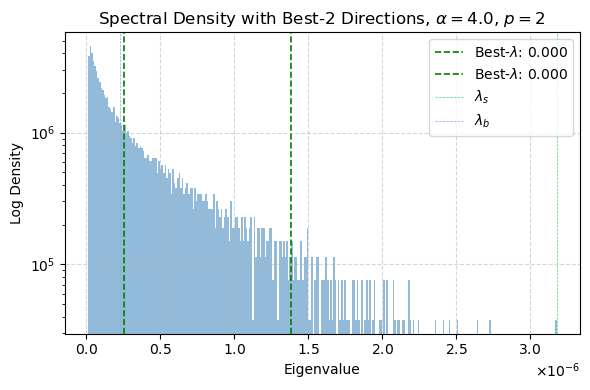

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from matplotlib.ticker import ScalarFormatter
import itertools


def bessel_ratio_approx(y):
    """Approximate the Bessel ratio K1/K0 using a rational function."""
    abs_y = np.abs(y)
    a1, a2 = 0.5, 0.1
    b1, b2 = 0.4, 0.05
    num = 1 + a1 * abs_y + a2 * abs_y**2
    den = 1 + b1 * abs_y + b2 * abs_y**2
    return np.where(den > 1e-6, num / den, 0.0)


def compute_T_y_pade(y_batch):
    """Construct T(y) using a Pade approximation for the Bessel ratio."""
    abs_y = np.abs(y_batch)
    ratio = bessel_ratio_approx(y_batch)
    lambda_y = abs_y * ratio
    T_list = []
    for i in range(len(y_batch)):
        y_i = y_batch[i]
        lam = lambda_y[i]
        G = np.array([[lam, y_i], [y_i, lam]])
        T_i = G @ np.linalg.inv(G + np.eye(2))
        T_list.append(T_i)
    return np.array(T_list)


def build_T_hat(X, T_y):
    """Construct the block-structured spectral matrix T_hat."""
    n, d = X.shape
    T_matrix = np.zeros((2 * d, 2 * d))
    for i in range(n):
        xi = X[i]
        Ti = T_y[i]
        A = np.outer(xi, xi)
        # Blockwise accumulation equivalent to a Kronecker structure
        T_matrix[0:d, 0:d]     += Ti[0, 0] * A
        T_matrix[0:d, d:2*d]   += Ti[0, 1] * A
        T_matrix[d:2*d, 0:d]   += Ti[1, 0] * A
        T_matrix[d:2*d, d:2*d] += Ti[1, 1] * A
    T_matrix /= n
    return T_matrix


def compute_subspace_alignment(U_hat, W_star):
    """Compute normalized subspace alignment score."""
    p = W_star.shape[1]
    score = np.linalg.norm(U_hat.T @ W_star, ord='fro')**2 / p
    return score


def plot_spectrum_with_best2(eigvals, best2_indices, alpha, p,
                             signal_top=2, lambda_s=None, lambda_b=None, save_path=None):
    """Plot spectral density and highlight the best-2 overlap eigenvalues."""
    bulk_color = '#2878B5'
    signal_color = 'green'

    hist, bin_edges = np.histogram(eigvals, bins=300, density=True)
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    plt.figure(figsize=(6, 4))
    for i in range(len(hist)):
        plt.bar(bin_centers[i], hist[i], width=bin_width, color=bulk_color, alpha=0.5)

    # Highlight the best-2 eigenvalues
    for idx in best2_indices:
        val = eigvals[idx]
        plt.axvline(val, color='green', linestyle='--', linewidth=1.2, label=f'Best-$\\lambda$: {val:.3f}')

    if lambda_s is not None:
        plt.axvline(lambda_s, color='#36E072', linestyle='--', linewidth=0.5, label=r'$\lambda_s$')
    if lambda_b is not None:
        plt.axvline(lambda_b, color='#85A7E7', linestyle='--', linewidth=0.5, label=r'$\lambda_b$')

    plt.yscale('log')
    plt.title(r"Spectral Density with Best-2 Directions, $\alpha={:.1f}$, $p={}$".format(alpha, p))
    plt.xlabel("Eigenvalue")
    plt.ylabel("Log Density")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()

    ax = plt.gca()
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


def main():
    # Parameter settings
    d = 1250
    p = 2
    alpha = 4
    n = int(d * alpha)
    np.random.seed(42)

    # Generate true signal subspace
    W_star = np.random.randn(d, p)
    W_star, _ = np.linalg.qr(W_star)

    # Generate synthetic data
    X = np.random.randn(n, d) / np.sqrt(d)
    Z = X @ W_star
    y = Z[:, 0] * Z[:, 1]

    # Build spectral estimator and perform eigen-decomposition
    T_y = compute_T_y_pade(y)
    T_hat = build_T_hat(X, T_y)
    eigvals, eigvecs = eigh(T_hat)

    # Subspace alignment using last p eigenvectors
    top_indices = np.argsort(eigvals)[-p:]
    V_top = eigvecs[:, top_indices]
    U_hat = []
    for i in range(p):
        u = V_top[:, i].reshape(d, p)
        u, _, _ = np.linalg.svd(u, full_matrices=False)
        U_hat.append(u[:, 0])
    U_hat = np.stack(U_hat, axis=1)
    score_max = compute_subspace_alignment(U_hat, W_star)
    print(f"[Last-{p}] Subspace alignment score: {score_max:.4f}")

    # Search all pairs of eigenvectors to find the best-2 overlap
    best_score = -1
    best_pair = None
    for i, j in itertools.combinations(range(2*d), 2):
        V_sel = eigvecs[:, [i, j]]
        U_temp = []
        for k in range(2):
            u = V_sel[:, k].reshape(d, p)
            u, _, _ = np.linalg.svd(u, full_matrices=False)
            U_temp.append(u[:, 0])
        U_temp = np.stack(U_temp, axis=1)
        score = compute_subspace_alignment(U_temp, W_star)
        if score > best_score:
            best_score = score
            best_pair = (i, j)

    print(f"[Best-2 overlap] Subspace alignment score: {best_score:.4f}")
    print(f"Best-2 eigvec indices: {sorted(best_pair)}")
    print(f"Corresponding eigenvalues: [{eigvals[best_pair[0]]:.3f}, {eigvals[best_pair[1]]:.3f}]")

    # Plot spectral density and highlight the best-2 eigenvalues
    lambda_s = eigvals[-1]
    lambda_b = eigvals[d - 1]
    plot_spectrum_with_best2(
        eigvals=eigvals,
        best2_indices=best_pair,
        alpha=alpha,
        p=p,
        signal_top=2,
        lambda_s=lambda_s,
        lambda_b=lambda_b,
        save_path=None
    )


if __name__ == "__main__":
    main()


<>:84: SyntaxWarning: invalid escape sequence '\l'
<>:84: SyntaxWarning: invalid escape sequence '\l'
/var/folders/kl/6hy0lk_14w14xqln8byr8l940000gn/T/ipykernel_32400/1068072530.py:84: SyntaxWarning: invalid escape sequence '\l'
  label=f'Best-$\lambda$: {val:.3e}')


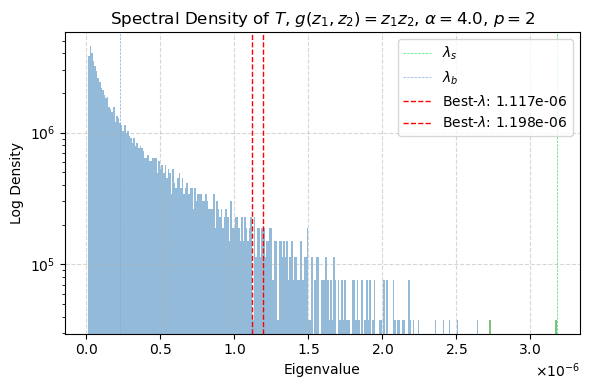

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from matplotlib.ticker import ScalarFormatter


def bessel_ratio_approx(y):
    """Approximate the Bessel function ratio K1/K0 using a rational approximation."""
    abs_y = np.abs(y)
    a1, a2 = 0.5, 0.1
    b1, b2 = 0.4, 0.05
    num = 1 + a1 * abs_y + a2 * abs_y**2
    den = 1 + b1 * abs_y + b2 * abs_y**2
    return np.where(den > 1e-6, num / den, 0.0)


def compute_T_y_pade(y_batch):
    """Construct T(y) matrix for each sample using the approximated Bessel ratio."""
    abs_y = np.abs(y_batch)
    ratio = bessel_ratio_approx(y_batch)
    lambda_y = abs_y * ratio

    T_list = []
    for i in range(len(y_batch)):
        y_i = y_batch[i]
        lam = lambda_y[i]
        G = np.array([[lam, y_i], [y_i, lam]])
        T_i = G @ np.linalg.inv(G + np.eye(2))
        T_list.append(T_i)
    return np.array(T_list)  # shape: (n, 2, 2)


def build_T_hat(X, T_y):
    """Construct the global spectral matrix T_hat using Kronecker-style aggregation."""
    n, d = X.shape
    T_matrix = np.zeros((2 * d, 2 * d))
    for i in range(n):
        xi = X[i]         # shape: (d,)
        Ti = T_y[i]       # shape: (2, 2)
        A = np.outer(xi, xi)  # outer product: (d, d)

        # Aggregate into block matrix according to T_i
        T_matrix[0:d, 0:d]     += Ti[0, 0] * A
        T_matrix[0:d, d:2*d]   += Ti[0, 1] * A
        T_matrix[d:2*d, 0:d]   += Ti[1, 0] * A
        T_matrix[d:2*d, d:2*d] += Ti[1, 1] * A
    T_matrix /= n
    return T_matrix


def plot_spectrum_fixed(eigvals, alpha, p, signal_top=2,
                        lambda_s=None, lambda_b=None,
                        highlight_values=None, save_path=None):
    """Plot the log-scale spectral density with optional reference lines and highlights."""
    bulk_color = '#2878B5'
    signal_color = 'green'
    highlight_color = 'red'

    hist, bin_edges = np.histogram(eigvals, bins=300, density=True)
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Identify bins corresponding to signal eigenvalues
    eigvals_sorted = np.sort(eigvals)
    signal_eigs = eigvals_sorted[-signal_top:]
    signal_bins = set([np.argmin(np.abs(bin_centers - eig)) for eig in signal_eigs])

    plt.figure(figsize=(6, 4))
    for i in range(len(hist)):
        color = signal_color if i in signal_bins else bulk_color
        plt.bar(bin_centers[i], hist[i], width=bin_width, color=color, alpha=0.5)

    if lambda_s is not None:
        plt.axvline(lambda_s, color='#36E072', linestyle='--', linewidth=0.5, label=r'$\lambda_s$')
    if lambda_b is not None:
        plt.axvline(lambda_b, color='#85A7E7', linestyle='--', linewidth=0.5, label=r'$\lambda_b$')

    if highlight_values is not None:
        for val in highlight_values:
            plt.axvline(val, color=highlight_color, linestyle='--', linewidth=1.0,
                        label=f'Best-$\lambda$: {val:.3e}')

    plt.yscale('log')
    plt.title(r"Spectral Density of $T$, $g(z_1,z_2) = z_1 z_2$, $\alpha = {:.1f}$, $p = {}$".format(alpha, p))
    plt.xlabel("Eigenvalue")
    plt.ylabel("Log Density")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()

    ax = plt.gca()
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


def main():
    # Parameter configuration
    d = 1250
    p = 2
    alpha = 4
    n = int(d * alpha)
    np.random.seed(42)

    # Generate signal subspace
    W_star = np.random.randn(d, p)
    W_star, _ = np.linalg.qr(W_star)

    # Generate synthetic observations
    X = np.random.randn(n, d) / np.sqrt(d)
    Z = X @ W_star
    z1, z2 = Z[:, 0], Z[:, 1]
    y = z1 * z2  # link function

    # Construct T(y) using rational approximation
    T_y = compute_T_y_pade(y)

    # Build spectral matrix
    T_hat = build_T_hat(X, T_y)

    # Eigendecomposition
    eigvals, eigvecs = eigh(T_hat)

    # Extract thresholds
    lambda_s = eigvals[-1]
    lambda_b = eigvals[d - 1]

    # Manually specified eigenvalue indices with best overlap
    best_2_indices = [2284, 2317]
    best_2_values = [eigvals[i] for i in best_2_indices]

    # Visualize spectrum
    plot_spectrum_fixed(
        eigvals=eigvals,
        alpha=alpha,
        p=p,
        signal_top=2,
        lambda_s=lambda_s,
        lambda_b=lambda_b,
        highlight_values=best_2_values
    )


if __name__ == "__main__":
    main()


Using manual bulk edge λ_b = 0.0000


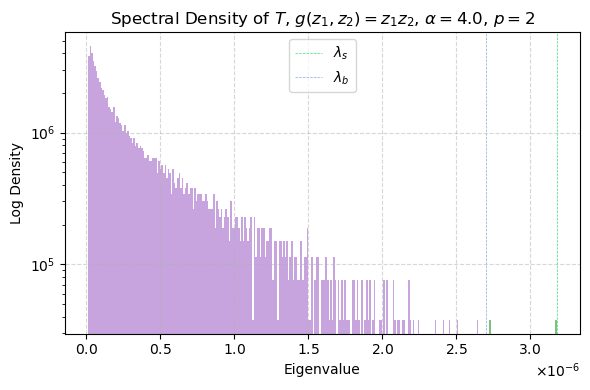

Subspace Alignment Score (normalized): 0.0011


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from matplotlib.ticker import ScalarFormatter


def bessel_ratio_approx(y):
    """Approximate the Bessel ratio K1(y)/K0(y) using a rational function."""
    abs_y = np.abs(y)
    a1, a2 = 0.5, 0.1
    b1, b2 = 0.4, 0.05
    num = 1 + a1 * abs_y + a2 * abs_y**2
    den = 1 + b1 * abs_y + b2 * abs_y**2
    return np.where(den > 1e-6, num / den, 0.0)


def compute_T_y_pade(y_batch):
    """Compute T(y) matrices for each response using the approximated Bessel ratio."""
    abs_y = np.abs(y_batch)
    ratio = bessel_ratio_approx(y_batch)
    lambda_y = abs_y * ratio

    T_list = []
    for i in range(len(y_batch)):
        y_i = y_batch[i]
        lam = lambda_y[i]
        G = np.array([[lam, y_i], [y_i, lam]])
        T_i = G @ np.linalg.inv(G + np.eye(2))
        T_list.append(T_i)
    return np.array(T_list)  # shape: (n, 2, 2)


def build_T_hat(X, T_y):
    """Construct the global spectral estimator matrix T_hat."""
    n, d = X.shape
    T_matrix = np.zeros((2 * d, 2 * d))
    for i in range(n):
        xi = X[i]          # shape: (d,)
        Ti = T_y[i]        # shape: (2, 2)
        A = np.outer(xi, xi)  # shape: (d, d)

        # Kronecker-style aggregation
        T_matrix[0:d, 0:d]     += Ti[0, 0] * A
        T_matrix[0:d, d:2*d]   += Ti[0, 1] * A
        T_matrix[d:2*d, 0:d]   += Ti[1, 0] * A
        T_matrix[d:2*d, d:2*d] += Ti[1, 1] * A
    T_matrix /= n
    return T_matrix


def plot_spectrum_fixed(eigvals, alpha, p, signal_top=2, lambda_s=None, lambda_b=None, save_path=None):
    """Plot the log-density spectrum and highlight top eigenvalues and thresholds."""
    bulk_color = '#914BBF'
    signal_color = 'green'

    hist, bin_edges = np.histogram(eigvals, bins=300, density=True)
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Identify bins corresponding to top signal eigenvalues
    eigvals_sorted = np.sort(eigvals)
    signal_eigs = eigvals_sorted[-signal_top:]
    signal_bins = set([np.argmin(np.abs(bin_centers - eig)) for eig in signal_eigs])

    plt.figure(figsize=(6, 4))
    for i in range(len(hist)):
        color = signal_color if i in signal_bins else bulk_color
        plt.bar(bin_centers[i], hist[i], width=bin_width, color=color, alpha=0.5)

    if lambda_s is not None:
        plt.axvline(lambda_s, color='#36E072', linestyle='--', linewidth=0.5, label=r'$\lambda_s$')
    if lambda_b is not None:
        plt.axvline(lambda_b, color='#85A7E7', linestyle='--', linewidth=0.5, label=r'$\lambda_b$')

    plt.yscale('log')
    plt.title(r"Spectral Density of $T$, $g(z_1,z_2) = z_1 z_2$, $\alpha = {:.1f}$, $p = {}$".format(alpha, p))
    plt.xlabel("Eigenvalue")
    plt.ylabel("Log Density")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()

    ax = plt.gca()
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


def compute_alignment_score(eigvecs, W_star, d, p):
    """
    Recover W_hat ∈ ℝ^{d×p} from top eigenvectors of T_hat,
    then compute subspace alignment score against ground truth W_star.
    """
    W_hat_list = []
    for i in range(p):
        v = eigvecs[:, -1 - i]  # select top p eigenvectors (descending)
        mat = v.reshape(d, p)
        u, _, _ = np.linalg.svd(mat, full_matrices=False)
        W_hat_list.append(u[:, 0])  # leading direction
    W_hat = np.stack(W_hat_list, axis=1)  # (d, p)

    score = np.linalg.norm(W_hat.T @ W_star, ord='fro')**2 / p
    return score


def main():
    # Basic configuration
    d = 1250
    p = 2
    alpha = 4
    n = int(d * alpha)
    np.random.seed(42)

    # Generate signal subspace
    W_star = np.random.randn(d, p)
    W_star, _ = np.linalg.qr(W_star)

    # Generate data
    X = np.random.randn(n, d) / np.sqrt(d)
    Z = X @ W_star
    z1, z2 = Z[:, 0], Z[:, 1]
    y = z1 * z2  # non-linear link

    # Compute preprocessed T(y)
    T_y = compute_T_y_pade(y)

    # Build spectral estimator
    T_hat = build_T_hat(X, T_y)

    # Eigendecomposition
    eigvals, eigvecs = eigh(T_hat, eigvals_only=False)

    # Compute spectral thresholds
    lambda_s = eigvals[-1]  # largest eigenvalue (signal)

    manual_lambda_b = 2.7e-6  # Optional manual threshold for bulk edge
    if manual_lambda_b is not None:
        lambda_b = manual_lambda_b
        print(f"Using manual bulk edge λ_b = {lambda_b:.4f}")
    else:
        lambda_b = eigvals[d - 1]
        print(f"Using default bulk edge λ_b = λ_{d} = {lambda_b:.4f}")

    # Visualize spectrum
    plot_spectrum_fixed(
        eigvals=eigvals,
        alpha=alpha,
        p=p,
        signal_top=2,
        lambda_s=lambda_s,
        lambda_b=lambda_b
    )

    # Compute alignment score
    score = compute_alignment_score(eigvecs, W_star, d, p)
    print(f"Subspace Alignment Score (normalized): {score:.4f}")


if __name__ == "__main__":
    main()
